# Homework 7 Problem 1
## Austin Marga

First, let's start with our import statements that we will need.

In [1]:
import pandas as pd
from fft import fft_power
import numpy as np
from scipy.signal import find_peaks
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First, let's fetch the `month.txt` file with all the data that was used previously and plot the result. This should be the same as the beginning in HW6. I have `month.txt` within the same directory.

Text(0, 0.5, 'log(Monthly Methane) (ppb)')

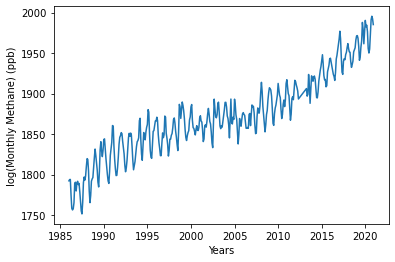

In [2]:
filename = "Month.txt"
data2 = pd.read_csv(filename,skiprows = 139, sep = " ",na_values = [-999.99,-99.99])
data = data2.dropna()
plt.plot(data["time_decimal"], data["value"])
plt.xlabel("Years")
plt.ylabel("log(Monthly Methane) (ppb)")

Next, let's take the fast fourier transform (FFT) of our y-data to bring it to the frequency domain and see what happens. In order to do this, we need to do the following:
- Send the x and y values to numpy for ease of performing mathematical operations
- Apply the fft to the y values
- Plot the function

410
410
410


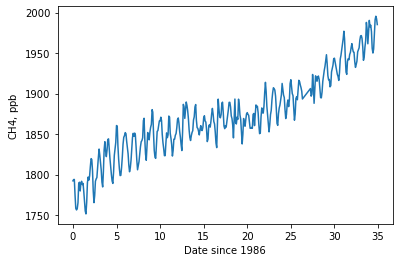

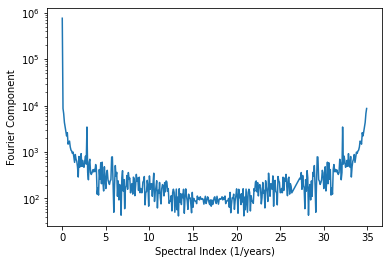

In [3]:
n = len(data["value"])
print(n)
x= data["time_decimal"]
x = (x - 1986)
y = data["value"]
print(len(y))
x = x.to_numpy()
y = y.to_numpy()
Y = np.fft.fft(y)
Y_abs = abs(Y)
print(len(Y_abs))
f2 = plt.figure(1)
plt.plot(x,y)
plt.ylabel('CH${4}$, ppb')
plt.xlabel('Date since 1986')

f2 = plt.figure(2)
plt.plot( x, Y_abs )
plt.yscale('log')
plt.ylabel('Fourier Component')

plt.xlabel('Spectral Index (1/years)')
plt.show()

In [4]:
Y_abs = Y_abs.tolist()
print(len(Y_abs))

410


First, let's try to find the maximums of the fourier spectrum, or the frequencies. We can do this by this `range_search` function. I have decided to partition the `Y_abs` data into 5 partitions, and look for the maximum y values in each of these partitions. The larger the y value, the larger the fourier coefficient on the sine function, which means it has relatively stronger periodicity.

In [5]:
def range_search(lst,part):
    """
    Searches for the maximum in a certain number of partitions of the data lst.
    
    Args: lst is a list of data to find the maximum of. 
          part is the number of partitions you want to split the data up into. 
          
    Returns: returns a list of lists, first entry is the maximum values, the second is a list of the indexes of the max vals.
    
    
    """
    N = len(lst)
    a = 0
    maxes = []
    idx = []
    for section in arange(0,part):
        end = N//part
        block = lst[(0+end*a):(end*(a+1))]
        block_max = max(block)
        max_index = lst.index(block_max)
        maxes.append(block_max)
        idx.append(max_index)
        a = a+1
    return [maxes,idx]

In [6]:
output = range_search(Y_abs,5)
peak_idx = output[1] 

Output gives us the coefficient of the fourier component in the first list, and a list of the indices with the largest coefficients. Now, we want to find the x values of these indices to find the frequencies that are the highest.

For some reason, my last index is 1, which means my function somehow wrapped around to the beginning of the list again. I don't know how to resolve this.

In [7]:
print(output)

[[767318.4800000001, 397.3815259510481, 161.03238558930266, 397.38152595104845, 8699.188404019005], [0, 83, 170, 327, 1]]


We can also use the `scipy.signal` library to find the peaks using the `find_peaks` function. I will use my own function, but this is also a candidate. The only problem is that it selects every possible relative maximum. For data with relatively high fluctuations, this may not be helpful in determining the correct frequencies. 

In [8]:
he = find_peaks(Y_abs)
# print(len(Y_abs))
# print(type((he[0])))
x_sci = he[0].tolist()
# print(type(x_sci))

In [9]:
#
def x_peaks(idx_lst,new_lst):
    """
    Finds the x values at given indices.
    
    Args: idx_lst is a list of indices that we want the x_values of.
          new_lst is the list of data we want to find the values of (the x list).
          
    Returns: returns a list of peak values along the x-axis.
    
    """
    peaks = []
    for entry in idx_lst:
        peaks.append(new_lst[entry])
    return peaks
print(x_peaks(peak_idx,x))

[0.0, 6.915300546447952, 14.163934426229616, 28.08493150684876, 0.08493150684876127]


### My actual frequencies are the following:
 - Every 0.00 years (must be an artifact of the fourier transform)
 - Every 6.92 years
 - Every 12.16 years
 - Every 28.08 years
 - Every 0.08 years (this one seems to be incorrect)

My function that partitions the data is likely incorrect, but this is the idea that should be pursued.

## Padding and Windowing the Data

In the frequency domain, the x-axis is in (1/years). If you eyeball the data in `Month.txt` and we can see that there is a maximum roughly every 10-12 steps. This means that there is some sort of sinusoidal behavior in the y-values that happens yearly (hence the 1/year).

Additionally, 'n' is our number of data points. It would be preferable if `n` was a power of two for the fft to run faster as we covered in class. Therefore, let's pad the data to get it up to that point.

The code for padding the data was taken directly from the `fft_padding.ipynb` notebook that was provided by the instructor. 

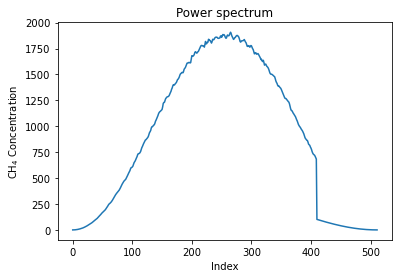

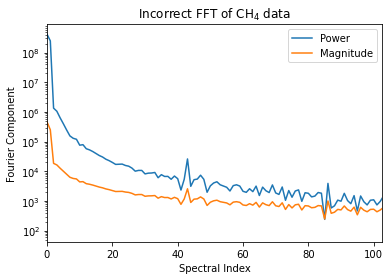

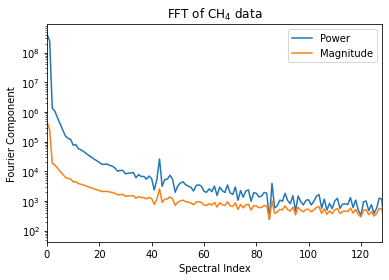

In [10]:
window = True

log2n = math.log(n, 2)
next_pow_of_2 = int(log2n) + 1
if log2n - int(log2n) > 0.0 :    
    ypads = np.full( 2**( next_pow_of_2) - n, 300, dtype=np.double)
    y = np.concatenate( (y, ypads) )
    # CAREFUL: When you pad, the x axis becomes somewhat "meaningless" for the padded values, 
    # so typically it is best to just consider it an index
    x = np.arange(len(y))
    N = len(y)
    # Apply a window to reduce ringing from the 2^n cutoff
    if window : 
        y = y * (0.5 - 0.5 * np.cos(2*np.pi*x/(N-1)))
                

Y = np.fft.fft(y)
Y_abs = abs(Y)
powery = fft_power(Y)
powerx = np.arange(powery.size)

f1 = plt.figure(1)
plt.plot( x, y )
plt.xlabel("Index")
plt.ylabel("CH$_4$ Concentration")
plt.title("Power spectrum")

#This is the incorrect plot. See that the `xlim` is using our unpadded value of `n`.
f2 = plt.figure(2)
plt.plot( powerx, powery, label="Power" )
plt.plot( x, Y_abs, label="Magnitude" )
plt.xlim([0,n/4])
plt.legend()
plt.yscale('log')
plt.xlabel("Spectral Index")
plt.ylabel("Fourier Component")
plt.title("Incorrect FFT of CH$_4$ data")


#Let's see the correct plot. Let's change this to the padded value `N`.

f3 = plt.figure(3)
plt.plot( powerx, powery, label="Power" )
plt.plot( x, Y_abs, label="Magnitude" )
plt.xlim([0,N/4])
plt.legend()
plt.yscale('log')
plt.xlabel("Spectral Index")
plt.ylabel("Fourier Component")
plt.title("FFT of CH$_4$ data")
plt.show()

## Difference from padding
We see that the plots do not look significantly different between the unpadded (incorrect) data and the padded (correct) data. This makes sense, as the point of padding the data is to reduce the runtime of the FFT function by having the data as a power of 2. In this case, we pad the data to bring it to be up to 128 points.

## Cutting the high frequency

I am unsure as to what frequency to cut, so let's try to cut the high frequency data. This code was taken from the `fft.filtering.ipynb` notebook provided by the instructor. We can plot the power spectrum and the fourier space with the high frequency cut off.

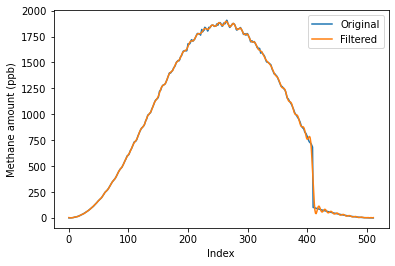

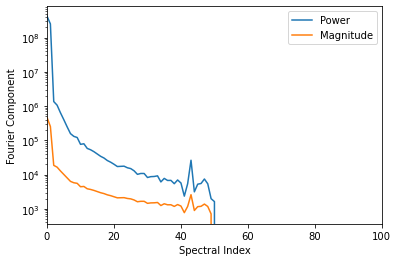

In [11]:
maxfreq = 50
Y[maxfreq:len(Y)-maxfreq] = 0.0
# Get the absolute value and power for plotting
Y_abs = abs(Y)
powery = fft_power(Y)
powerx = np.arange(powery.size)

# Now go back to the frequency domain. 
# Compare the data before and after filtering. 
yfiltered = ifft(Y)
yfiltered_abs= abs(yfiltered)



f4 = plt.figure(4)
plt.plot( x, y, label='Original' )
plt.plot( x, yfiltered_abs, label='Filtered' )
plt.xlabel("Index")
plt.ylabel("Methane amount (ppb)")
plt.legend()

f5 = plt.figure(5)
plt.plot( powerx, powery, label="Power" )
plt.plot( x, Y_abs, label="Magnitude" )
plt.legend()
plt.xlim([0,maxfreq*2])
plt.yscale('log')
plt.xlabel("Spectral Index")
plt.ylabel("Fourier Component")

plt.show()

I attempted to take the inverse fourier transform of the y component to bring it back to real space. This would allow me to look at the data after the effect of cutting the high frequency signals. I got an error as a result.

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


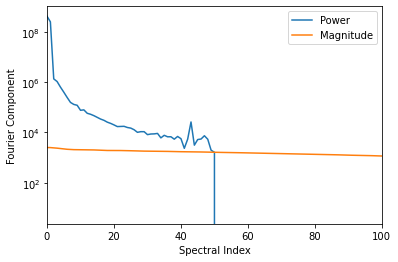

In [12]:
f6 = plt.figure(6)
plt.plot( powerx, powery, label="Power" )
plt.plot( x, np.fft.ifft(Y_abs), label="Magnitude" )
plt.legend()
plt.xlim([0,maxfreq*2])
plt.yscale('log')
plt.xlabel("Spectral Index")
plt.ylabel("Fourier Component")

plt.show()